In [29]:
"""
Code pulled from:
https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
"""

'\nCode pulled from:\nhttps://kapernikov.com/tutorial-image-classification-with-scikit-learn/\n'

In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})cell images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)

            for file in os.listdir(current_path):
                 if file[-4:] == 'jpeg':
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [3]:
data_path = fr'dataset2-master/dataset2-master/images/TEST/'
os.listdir(data_path)

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']

In [4]:
base_name = 'cells'
width = 80
 
include = {'NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 
           'LYMPHOCYTE'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

NEUTROPHIL
MONOCYTE
EOSINOPHIL
LYMPHOCYTE


In [5]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  2487
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)cell images in rgb
image shape:  (80, 80, 3)
labels: ['EOSINO' 'LYMPHO' 'MONO' 'NEUTRO']


Counter({'NEUTRO': 624, 'MONO': 620, 'EOSINO': 623, 'LYMPHO': 620})

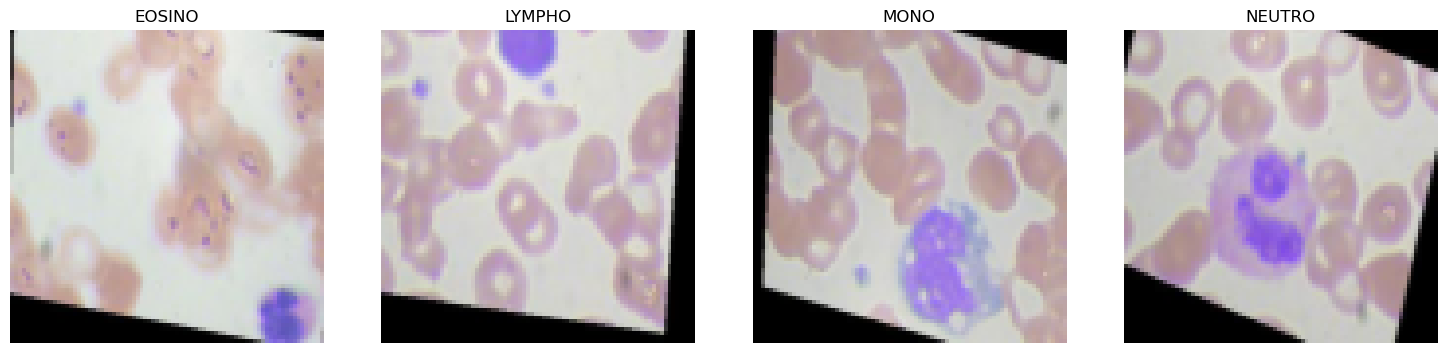

In [39]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [7]:
X = np.array(data['data'])
y = np.array(data['label'])

In [8]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(1989, 576)


In [15]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [16]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

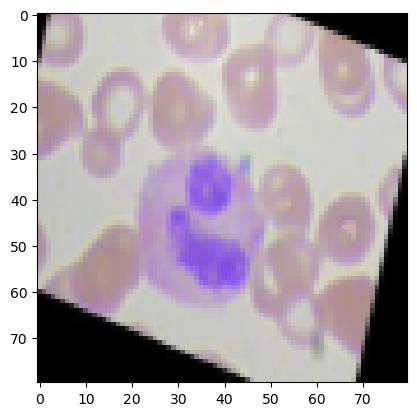

In [40]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

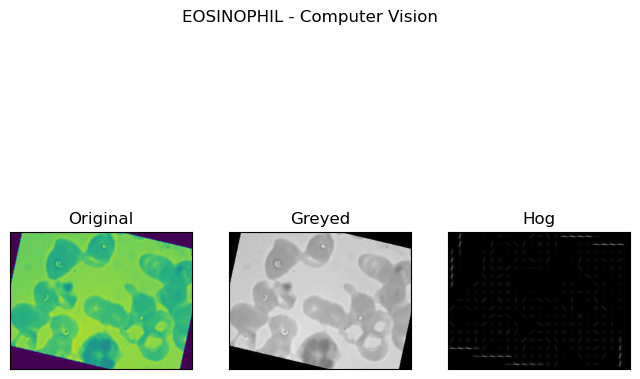

In [71]:
cell = fr'dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg'
def disp_compVision(path):
    cell = imread(path,as_gray=True)
    # calculate the hog and return a visual representation.
    cell_hog, cell_hog_img = hog(
        cell, pixels_per_cell=(14,14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        visualize=True, 
        block_norm='L2-Hys')

    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(8,6)
    # remove ticks and their labels
    [a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
        for a in ax]
    
    cell_type = path.split('/')[-2]

    fig.suptitle(cell_type + " - Computer Vision")
    ax[0].imshow(cell)
    ax[0].set_title('Original')
    ax[1].imshow(cell, cmap='gray')
    ax[1].set_title('Greyed')
    ax[2].imshow(cell_hog_img, cmap='gray')
    ax[2].set_title('Hog')
    plt.show()
disp_compVision(cell)

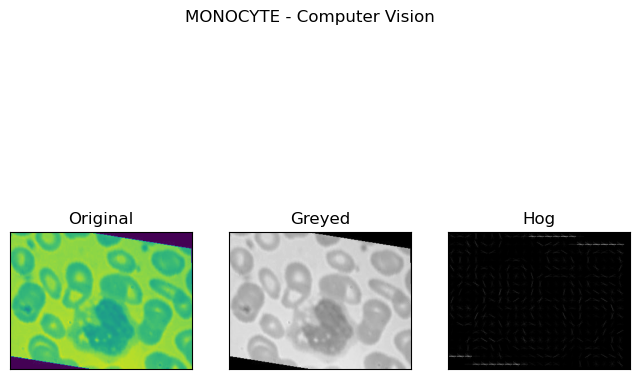

In [73]:
cell_2 = fr'dataset2-master/dataset2-master/images/TEST/MONOCYTE/_0_1588.jpeg'
disp_compVision(cell_2)

In [21]:
y_pred = sgd_clf.predict(X_test_prepared)

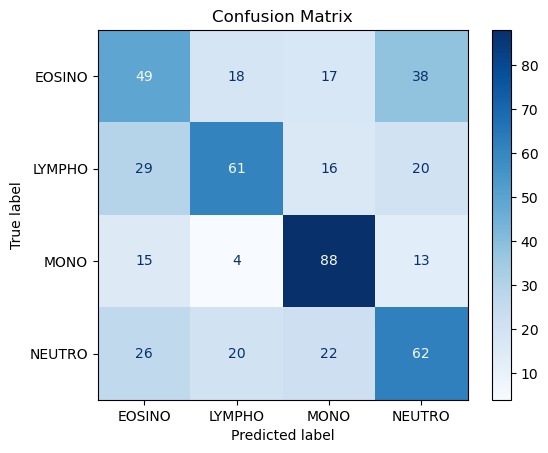

accuracy: 52.21%


In [63]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import pandas as pd

cmx = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmx,display_labels = labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(f"accuracy: {round(np.trace(cmx)/np.sum(cmx)*100,2)}%")